In [1]:
"""
這份檔案要用來執行訓練行的部分，主要利用catboost來訓練模型，可透過參數利用GPU進行運算

input：特徵處理完的training dataset(processed_data.parquet)、validation dataset(val_data.parquet)

output：最終final_prediction 


"""

'\n這份檔案要用來執行訓練行的部分，主要利用catboost來訓練模型，可透過參數利用GPU進行運算\n\ninput：特徵處理完的training dataset(processed_data.parquet)、validation dataset(val_data.parquet)\n\noutput：最終final_prediction \n\n\n'

In [23]:
import pandas as pd
import numpy as np
import datetime
import dask.dataframe as dd
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from scipy.stats import entropy
from lightgbm import LGBMClassifier


# 訓練模型

In [2]:
new_train_data = pd.read_parquet('processed_data.parquet')
new_val_data = pd.read_parquet('val_data.parquet')
example = pd.read_csv('dataset_1st/31_範例繳交檔案.csv')


In [3]:
cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour','city_change', 'country_change']

columns_to_drop = ['label', 'txkey', 'chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm']

# 從數據框中刪除指定的列
X = new_train_data.drop(columns=columns_to_drop)
y = new_train_data['label']


In [4]:
for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.35, 
    random_state=40, 
    stratify=y
)

train_pool = Pool(X_train, y_train,cat_features=cat_features)
test_pool = Pool(X_test, y_test,cat_features=cat_features)


In [5]:
"""
註記：若電腦為MAC系列，則須無法使用 task_type='GPU'，可將其註解並且開啟subsample，接受另外兩個參數再進行訓練，超參數皆無須調整

"""
catboost_model = CatBoostClassifier(
    iterations=5000,  
    learning_rate=0.0325,
    depth=7,
    loss_function='Logloss',
    eval_metric='F1',  
    early_stopping_rounds=800,
    random_seed=42,
    verbose=100,
    l2_leaf_reg=3,
    leaf_estimation_iterations=10,
#     colsample_bylevel=0.8,
#     subsample=0.85,
    max_ctr_complexity=10,
    task_type='GPU',
    scale_pos_weight = 9.484, # 9.45
    random_strength=3,
    grow_policy='Lossguide'
)

catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

0:	learn: 0.8692471	test: 0.8736018	best: 0.8736018 (0)	total: 108ms	remaining: 9m
100:	learn: 0.9047787	test: 0.9059661	best: 0.9061075 (99)	total: 9.55s	remaining: 7m 43s
200:	learn: 0.9231686	test: 0.9227506	best: 0.9228090 (195)	total: 19.8s	remaining: 7m 52s
300:	learn: 0.9323214	test: 0.9306422	best: 0.9306422 (300)	total: 30.1s	remaining: 7m 50s
400:	learn: 0.9401768	test: 0.9373239	best: 0.9374398 (399)	total: 40.1s	remaining: 7m 40s
500:	learn: 0.9457957	test: 0.9421383	best: 0.9421383 (500)	total: 49.9s	remaining: 7m 28s
600:	learn: 0.9509461	test: 0.9457635	best: 0.9457635 (600)	total: 59.6s	remaining: 7m 16s
700:	learn: 0.9549122	test: 0.9472054	best: 0.9472628 (698)	total: 1m 9s	remaining: 7m 3s
800:	learn: 0.9589452	test: 0.9497434	best: 0.9497985 (797)	total: 1m 18s	remaining: 6m 50s
900:	learn: 0.9627042	test: 0.9519801	best: 0.9519801 (900)	total: 1m 27s	remaining: 6m 37s
1000:	learn: 0.9659715	test: 0.9538395	best: 0.9538438 (999)	total: 1m 36s	remaining: 6m 25s
1100:

In [6]:
y_pred = catboost_model.predict(test_pool)

precision = precision_score(y_test, y_pred, average='binary', pos_label=1)

print(f"Precision: {precision}")


Precision: 0.8816859555833594


In [7]:
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)

print(f"Recall: {recall}")



Recall: 0.941544885177453


In [51]:
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# 計算精確度和召回率以及閾值
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 計算 F1 分數
f1_scores = 2 * recall * precision / (recall + precision)
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]

# 使用最佳閾值進行預測
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

# 計算調整後的精確度和召回率
adjusted_precision = precision_score(y_test, y_pred_custom)
adjusted_recall = recall_score(y_test, y_pred_custom)
adjusted_f1 = f1_score(y_test, y_pred_custom)

print(f"Best Threshold: {best_threshold}")
print(f"Adjusted Precision: {adjusted_precision}")
print(f"Adjusted Recall: {adjusted_recall}")
print(f"Adjusted F1 Score: {adjusted_f1}")

Best Threshold: 0.7924726969128955
Best Precision: 0.9491748595505618
Best Recall: 0.9029645093945721
f1_scores: 0.9254932169298584


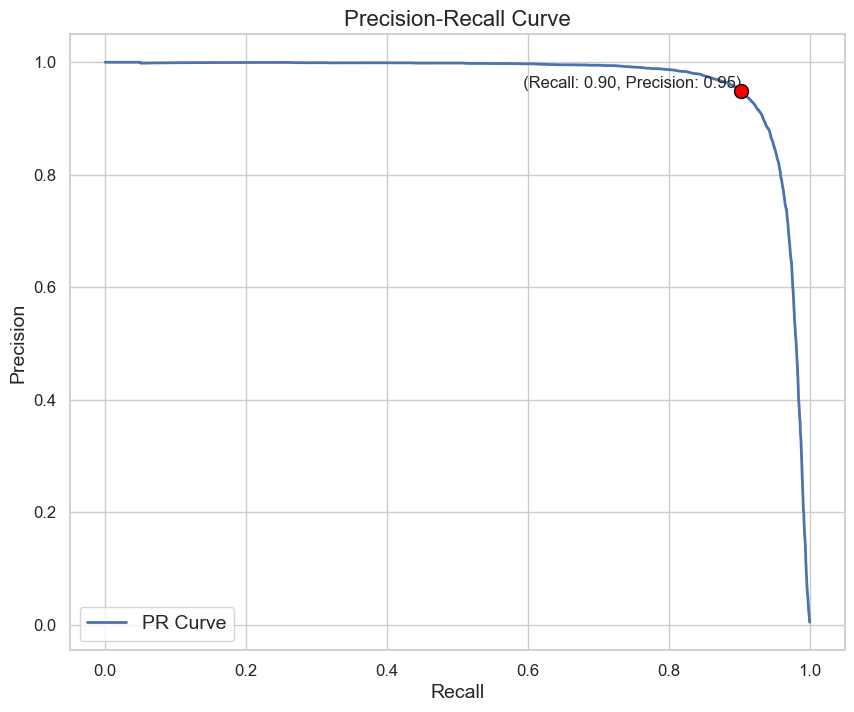

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置 seaborn 的風格
sns.set(style="whitegrid")

# 假設 precision, recall, best_recall, best_precision 已經定義好
# 繪製 Precision-Recall 曲線
plt.figure(figsize=(10, 8))
sns.lineplot(x=recall, y=precision, label='PR Curve', linewidth=2)

# 標記最佳點
plt.scatter(best_recall, best_precision, color='red', s=100, edgecolor='black', zorder=5)
plt.text(best_recall, best_precision, f'  (Recall: {best_recall:.2f}, Precision: {best_precision:.2f})', 
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

# 添加圖表標題和標籤
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 添加圖例
plt.legend(fontsize=14, loc='lower left')

# 顯示圖表
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))

for spw, model in zip(scale_pos_weight_values, models):
    y_pred_prob = model.predict_proba(test_pool)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'SPW={spw} (AUC = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different scale_pos_weight')
plt.legend()
plt.show()


In [10]:
# 查看特徵

feature_names =['locdt', 'loctm', 'contp', 'etymd', 'mchno', 'acqic', 'mcc', 
                'conam', 'ecfg', 'insfg', 'flam1', 'stocn', 'scity', 'stscd', 
                'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'card_transaction_count', 
                'customer_total_transactions', 'card_transaction_ratio_before_30', 
                'card_transaction_ratio_after_30', 'ratio_change', 'min_daily_trans', 
                'max_daily_trans', 'daily_transactions', 'normalized_trans_freq', 
                'normalized_daily_amount', 'difference_seconds', 'avg_interval', 
                'std_interval', 'transactions_per_mcc_x', 'mcc_total_amount_x', 
                'variance_transaction_amount_per_mcc_x', 'transactions_per_mcc_y', 
                'mcc_total_amount_y', 'variance_transaction_amount_per_mcc_y', 
                'mad_transaction_amount_per_mcc', 'transactions_per_mchno', 'mchno_total_amount', 
                'variance_transaction_amount_per_mchno', 'mad_transaction_amount_per_mchno', 
                'city_change', 'country_change', 'hour', 'loctm_seconds']

feature_importances = catboost_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


                                  Feature  Importance
29                           avg_interval    8.468756
18                 card_transaction_count    7.020192
19            customer_total_transactions    6.673849
22                           ratio_change    6.251935
30                           std_interval    6.212613
6                                     mcc    5.078966
38                 transactions_per_mchno    4.844085
4                                   mchno    4.264923
5                                   acqic    4.091834
31                 transactions_per_mcc_x    3.650362
11                                  stocn    3.419108
39                     mchno_total_amount    3.021122
37         mad_transaction_amount_per_mcc    2.873923
0                                   locdt    2.803130
32                     mcc_total_amount_x    2.235043
34                 transactions_per_mcc_y    2.200426
24                        max_daily_trans    2.041734
12                          

In [11]:
# Save the model to a file
model_path = 'dataset_2nd/model.cbm'
catboost_model.save_model(model_path, format='cbm')


# 預測和輸出資料

In [12]:
new_val_data = new_val_data.set_index('txkey')

In [13]:
columns_to_drop = ['chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm']

cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour','city_change', 'country_change']

X = new_val_data.drop(columns=columns_to_drop)

for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
test_pool = Pool(X, cat_features=cat_features)


In [14]:
y_pred = catboost_model.predict(test_pool).astype(int)
new_val_data['pred']= y_pred
new_val_data =new_val_data.reset_index()

output_df = new_val_data[['txkey', 'pred']].set_index('txkey')
example = example.drop_duplicates(subset='txkey')

df2_sorted = example[['txkey']].merge(output_df, on='txkey', how='left')
df2_sorted = df2_sorted.set_index('txkey')

In [15]:
output_filename = 'dataset_2nd/predictions_secondround.csv'
df2_sorted.to_csv(output_filename, index='True')

# 用PRC 修正


In [57]:
new_val_data = new_val_data.set_index('txkey')
columns_to_drop = ['chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm']

cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour','city_change', 'country_change']

X = new_val_data.drop(columns=columns_to_drop)

for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
test_pool = Pool(X, cat_features=cat_features)


In [58]:
y_pred_proba = catboost_model.predict_proba(test_pool)[:, 1]
y_pred_custom = (y_pred_proba > best_threshold).astype(int)
new_val_data['pred'] = y_pred_custom
new_val_data = new_val_data.reset_index()
output_df = new_val_data[['txkey', 'pred']].set_index('txkey')
example = example.drop_duplicates(subset='txkey')

df2_sorted = example[['txkey']].merge(output_df, on='txkey', how='left')
df2_sorted = df2_sorted.set_index('txkey')


In [59]:
df2_sorted

,pred
txkey,
a2c1209018e4e52e04f6fabb48f05f1b8bc09dc838ff6cb19906377fab414587,0
16c4880500059e01553789be11bbb50753b7acaae7b95bdcf6fb293a4d4a6e36,0
623c56be3bee87724e3d119c271d9ed098eeda842331830bcdcdee205329a531,0
250da12187059cf6e3a3066656a2919d08ceb8207efd550b3cf64eb47ae64d4d,0
4b268e0da036f44cbbb056ddfac6a28ea336d9cf299843bc7d40f3f7cb6c2d9f,0
...,...
47cd55bd7492e01e197b61799d072e6ca9e1c118bc76e924176566adab0d2b29,0
26cef9cc35fb73bedd08a711ebb6d612e4af7dd7b62e7c782aa58760bddd9cbc,0
f12f861ef6a8517ecddae262c1cc895f618e7e8c19eb9a768fc0b567e1e127d7,0
